In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import timm
# Note: Removed transformers import to avoid NumPy 2.0 compatibility issues
# We'll use TIMM exclusively for ViT models
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import os
from pathlib import Path
import json
from datetime import datetime
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"CUDA Version: {torch.version.cuda}")
print(f"PyTorch Version: {torch.__version__}")
print(f"TIMM Version: {timm.__version__}")
print(f"NumPy Version: {np.__version__}")


Using device: cuda
GPU: NVIDIA GeForce RTX 3060 Laptop GPU
CUDA Version: 12.6
PyTorch Version: 2.6.0+cu126
TIMM Version: 1.0.15
NumPy Version: 2.0.2


In [2]:
# Model hyperparameters from the paper
HYPERPARAMS = {
    'input_shape': (160, 160, 3),
    'num_classes': 2,
    'batch_size': 8,
    'epochs': 60,
    'learning_rate': 1e-4,
    'learning_rate_decay': 0.2,
    'patience_lr': 5,
    'patience_early_stop': 9,
    'validation_split': 0.1,
    'test_split': 0.1,
    'label_smoothing': 0.2,
    'epsilon': 1e-6,
    'weight_decay': 0.01
}

# Dataset paths
DATASET_PATH = Path('datasets_paper/2_class_dataset')
MODEL_SAVE_PATH = Path('models/2_class_pytorch')
RESULTS_PATH = Path('results/2_class_pytorch')

# Create directories
MODEL_SAVE_PATH.mkdir(parents=True, exist_ok=True)
RESULTS_PATH.mkdir(parents=True, exist_ok=True)

print("Hyperparameters:")
for key, value in HYPERPARAMS.items():
    print(f"  {key}: {value}")

print(f"\nDataset path: {DATASET_PATH}")
print(f"Model save path: {MODEL_SAVE_PATH}")
print(f"Results path: {RESULTS_PATH}")


Hyperparameters:
  input_shape: (160, 160, 3)
  num_classes: 2
  batch_size: 8
  epochs: 60
  learning_rate: 0.0001
  learning_rate_decay: 0.2
  patience_lr: 5
  patience_early_stop: 9
  validation_split: 0.1
  test_split: 0.1
  label_smoothing: 0.2
  epsilon: 1e-06
  weight_decay: 0.01

Dataset path: datasets_paper\2_class_dataset
Model save path: models\2_class_pytorch
Results path: results\2_class_pytorch


In [3]:
# Define transforms
train_transform = transforms.Compose([
    transforms.Resize((HYPERPARAMS['input_shape'][0], HYPERPARAMS['input_shape'][1])),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.3),
    transforms.RandomRotation(degrees=5),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((HYPERPARAMS['input_shape'][0], HYPERPARAMS['input_shape'][1])),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the full dataset
full_dataset = ImageFolder(root=DATASET_PATH, transform=train_transform)

# Calculate split sizes
total_size = len(full_dataset)
test_size = int(HYPERPARAMS['test_split'] * total_size)
val_size = int(HYPERPARAMS['validation_split'] * total_size)
train_size = total_size - test_size - val_size

print(f"Total dataset size: {total_size}")
print(f"Train size: {train_size}")
print(f"Validation size: {val_size}")
print(f"Test size: {test_size}")

# Split the dataset
train_dataset, val_dataset, test_dataset = random_split(
    full_dataset, 
    [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42)
)

# Apply different transforms to validation and test sets
val_dataset.dataset = ImageFolder(root=DATASET_PATH, transform=val_test_transform)
test_dataset.dataset = ImageFolder(root=DATASET_PATH, transform=val_test_transform)

# Create data loaders
train_loader = DataLoader(
    train_dataset, 
    batch_size=HYPERPARAMS['batch_size'], 
    shuffle=True, 
    num_workers=4, 
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset, 
    batch_size=HYPERPARAMS['batch_size'], 
    shuffle=False, 
    num_workers=4, 
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset, 
    batch_size=HYPERPARAMS['batch_size'], 
    shuffle=False, 
    num_workers=4, 
    pin_memory=True
)

# Get class names
class_names = full_dataset.classes
print(f"\nClasses: {class_names}")
print(f"Class to index mapping: {full_dataset.class_to_idx}")

print(f"\nData loaders created successfully!")
print(f"Train batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")


Total dataset size: 40000
Train size: 32000
Validation size: 4000
Test size: 4000

Classes: ['Anomaly', 'No-Anomaly']
Class to index mapping: {'Anomaly': 0, 'No-Anomaly': 1}

Data loaders created successfully!
Train batches: 4000
Validation batches: 500
Test batches: 500


In [4]:
class ViTClassifier(nn.Module):
    def __init__(self, num_classes=2, model_name='vit_base_patch32_224'):
        super(ViTClassifier, self).__init__()
        
        # Load pre-trained ViT-B/32 from TIMM
        self.backbone = timm.create_model(
            model_name, 
            pretrained=True,
            num_classes=0,  # Remove the classification head
            img_size=HYPERPARAMS['input_shape'][0]
        )
        
        # Get the feature dimension
        with torch.no_grad():
            dummy_input = torch.randn(1, 3, HYPERPARAMS['input_shape'][0], HYPERPARAMS['input_shape'][1])
            features = self.backbone(dummy_input)
            feature_dim = features.shape[1]
        
        # Custom classification head with ReLU activation
        self.classifier = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(feature_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )
        
        print(f"Model created with feature dimension: {feature_dim}")
        
    def forward(self, x):
        # Extract features using ViT backbone
        features = self.backbone(x)
        
        # Classification
        output = self.classifier(features)
        return output

# Create the model
model = ViTClassifier(num_classes=HYPERPARAMS['num_classes'])
model = model.to(device)

# Print model summary
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\nModel Summary:")
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Model moved to: {device}")

# Display model architecture
print("\nModel Architecture:")
print(model)


model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

Model created with feature dimension: 768

Model Summary:
Total parameters: 87,831,554
Trainable parameters: 87,831,554
Model moved to: cuda

Model Architecture:
ViTClassifier(
  (backbone): VisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32))
      (norm): Identity()
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (patch_drop): Identity()
    (norm_pre): Identity()
    (blocks): Sequential(
      (0): Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (q_norm): Identity()
          (k_norm): Identity()
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=768, out_features=768, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): Identity()
        (drop_path1): Identity()
        (norm2): LayerNorm((768,), ep

In [5]:
# Loss function with label smoothing
class LabelSmoothingCrossEntropy(nn.Module):
    def __init__(self, smoothing=0.1):
        super(LabelSmoothingCrossEntropy, self).__init__()
        self.smoothing = smoothing
        
    def forward(self, pred, target):
        confidence = 1. - self.smoothing
        log_probs = torch.log_softmax(pred, dim=1)
        nll_loss = -log_probs.gather(dim=1, index=target.unsqueeze(1))
        nll_loss = nll_loss.squeeze(1)
        smooth_loss = -log_probs.mean(dim=1)
        loss = confidence * nll_loss + self.smoothing * smooth_loss
        return loss.mean()

# Initialize loss function
criterion = LabelSmoothingCrossEntropy(smoothing=HYPERPARAMS['label_smoothing'])

# Initialize optimizer (AdamW as alternative to Rectified Adam)
optimizer = optim.AdamW(
    model.parameters(),
    lr=HYPERPARAMS['learning_rate'],
    weight_decay=HYPERPARAMS['weight_decay'],
    eps=HYPERPARAMS['epsilon']
)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=HYPERPARAMS['learning_rate_decay'],
    patience=HYPERPARAMS['patience_lr'],
    verbose=True,
    min_lr=1e-7
)

print("Training setup:")
print(f"Loss function: Label Smoothing CrossEntropy (smoothing={HYPERPARAMS['label_smoothing']})")
print(f"Optimizer: AdamW (lr={HYPERPARAMS['learning_rate']}, weight_decay={HYPERPARAMS['weight_decay']})")
print(f"Scheduler: ReduceLROnPlateau (factor={HYPERPARAMS['learning_rate_decay']}, patience={HYPERPARAMS['patience_lr']})")
print(f"Device: {device}")


Training setup:
Loss function: Label Smoothing CrossEntropy (smoothing=0.2)
Optimizer: AdamW (lr=0.0001, weight_decay=0.01)
Scheduler: ReduceLROnPlateau (factor=0.2, patience=5)
Device: cuda


In [6]:
def train_epoch(model, train_loader, criterion, optimizer, device):
    """Train the model for one epoch"""
    model.train()
    running_loss = 0.0
    running_corrects = 0
    total_samples = 0
    
    train_bar = tqdm(train_loader, desc='Training')
    for inputs, labels in train_bar:
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        # Statistics
        _, preds = torch.max(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        total_samples += inputs.size(0)
        
        # Update progress bar
        train_bar.set_postfix({
            'Loss': f'{loss.item():.4f}',
            'Acc': f'{running_corrects.double() / total_samples:.4f}'
        })
    
    epoch_loss = running_loss / total_samples
    epoch_acc = running_corrects.double() / total_samples
    
    return epoch_loss, epoch_acc.item()

def validate_epoch(model, val_loader, criterion, device):
    """Validate the model for one epoch"""
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    total_samples = 0
    
    with torch.no_grad():
        val_bar = tqdm(val_loader, desc='Validation')
        for inputs, labels in val_bar:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Statistics
            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            total_samples += inputs.size(0)
            
            # Update progress bar
            val_bar.set_postfix({
                'Loss': f'{loss.item():.4f}',
                'Acc': f'{running_corrects.double() / total_samples:.4f}'
            })
    
    epoch_loss = running_loss / total_samples
    epoch_acc = running_corrects.double() / total_samples
    
    return epoch_loss, epoch_acc.item()

print("Training and validation functions defined successfully!")


Training and validation functions defined successfully!


In [7]:
# Training history storage
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': [],
    'lr': []
}

# Early stopping variables
best_val_loss = float('inf')
best_val_acc = 0.0
patience_counter = 0
best_model_state = None

# Record training start time
start_time = datetime.now()
print(f"Training started at: {start_time}")
print(f"Max epochs: {HYPERPARAMS['epochs']}")
print(f"Early stopping patience: {HYPERPARAMS['patience_early_stop']}")
print("-" * 60)

# Training loop
for epoch in range(HYPERPARAMS['epochs']):
    print(f"\nEpoch {epoch+1}/{HYPERPARAMS['epochs']}")
    print("-" * 40)
    
    # Train for one epoch
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    
    # Validate for one epoch
    val_loss, val_acc = validate_epoch(model, val_loader, criterion, device)
    
    # Step the scheduler
    scheduler.step(val_loss)
    
    # Get current learning rate
    current_lr = optimizer.param_groups[0]['lr']
    
    # Store history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['lr'].append(current_lr)
    
    # Print epoch results
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    print(f"Learning Rate: {current_lr:.2e}")
    
    # Check for best model (based on validation accuracy)
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_val_loss = val_loss
        best_model_state = model.state_dict().copy()
        patience_counter = 0
        print(f"✅ New best model! Val Acc: {val_acc:.4f}")
        
        # Save the best model
        torch.save({
            'epoch': epoch,
            'model_state_dict': best_model_state,
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'best_val_acc': best_val_acc,
            'best_val_loss': best_val_loss,
            'hyperparams': HYPERPARAMS
        }, MODEL_SAVE_PATH / 'best_model.pth')
        
    else:
        patience_counter += 1
        print(f"⏳ No improvement. Patience: {patience_counter}/{HYPERPARAMS['patience_early_stop']}")
    
    # Early stopping check
    if patience_counter >= HYPERPARAMS['patience_early_stop']:
        print(f"\n🛑 Early stopping triggered after {epoch+1} epochs")
        print(f"Best validation accuracy: {best_val_acc:.4f}")
        break

# Record training end time
end_time = datetime.now()
training_duration = end_time - start_time

print(f"\n{'='*60}")
print("Training completed!")
print(f"Training duration: {training_duration}")
print(f"Best validation accuracy: {best_val_acc:.4f}")
print(f"Best validation loss: {best_val_loss:.4f}")
print(f"Total epochs trained: {len(history['train_loss'])}")

# Load the best model
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print("✅ Best model weights loaded")


Training started at: 2025-06-06 00:13:54.908250
Max epochs: 60
Early stopping patience: 9
------------------------------------------------------------

Epoch 1/60
----------------------------------------


Validation: 100%|██████████| 500/500 [00:19<00:00, 25.74it/s, Loss=0.5307, Acc=0.8217]


Train Loss: 0.5499, Train Acc: 0.7892
Val Loss: 0.5335, Val Acc: 0.8217
Learning Rate: 1.00e-04
✅ New best model! Val Acc: 0.8217

Epoch 2/60
----------------------------------------


Validation: 100%|██████████| 500/500 [00:20<00:00, 24.48it/s, Loss=0.4012, Acc=0.8722]


Train Loss: 0.5022, Train Acc: 0.8441
Val Loss: 0.4734, Val Acc: 0.8722
Learning Rate: 1.00e-04
✅ New best model! Val Acc: 0.8722

Epoch 3/60
----------------------------------------


Validation: 100%|██████████| 500/500 [00:19<00:00, 25.26it/s, Loss=0.3571, Acc=0.8762]


Train Loss: 0.4834, Train Acc: 0.8633
Val Loss: 0.4702, Val Acc: 0.8762
Learning Rate: 1.00e-04
✅ New best model! Val Acc: 0.8762

Epoch 4/60
----------------------------------------


Validation: 100%|██████████| 500/500 [00:20<00:00, 24.00it/s, Loss=0.3485, Acc=0.8310]


Train Loss: 0.4707, Train Acc: 0.8758
Val Loss: 0.5065, Val Acc: 0.8310
Learning Rate: 1.00e-04
⏳ No improvement. Patience: 1/9

Epoch 5/60
----------------------------------------


Validation: 100%|██████████| 500/500 [00:24<00:00, 20.46it/s, Loss=0.3348, Acc=0.8910]


Train Loss: 0.4612, Train Acc: 0.8846
Val Loss: 0.4587, Val Acc: 0.8910
Learning Rate: 1.00e-04
✅ New best model! Val Acc: 0.8910

Epoch 6/60
----------------------------------------


Validation: 100%|██████████| 500/500 [00:21<00:00, 23.10it/s, Loss=0.3347, Acc=0.8918]


Train Loss: 0.4520, Train Acc: 0.8927
Val Loss: 0.4502, Val Acc: 0.8918
Learning Rate: 1.00e-04
✅ New best model! Val Acc: 0.8918

Epoch 7/60
----------------------------------------


Validation: 100%|██████████| 500/500 [00:23<00:00, 21.66it/s, Loss=0.4960, Acc=0.9068]


Train Loss: 0.4460, Train Acc: 0.8972
Val Loss: 0.4389, Val Acc: 0.9068
Learning Rate: 1.00e-04
✅ New best model! Val Acc: 0.9068

Epoch 8/60
----------------------------------------


Validation: 100%|██████████| 500/500 [00:24<00:00, 20.50it/s, Loss=0.3406, Acc=0.9105]


Train Loss: 0.4389, Train Acc: 0.9049
Val Loss: 0.4341, Val Acc: 0.9105
Learning Rate: 1.00e-04
✅ New best model! Val Acc: 0.9105

Epoch 9/60
----------------------------------------


Validation: 100%|██████████| 500/500 [00:23<00:00, 20.92it/s, Loss=0.3517, Acc=0.9095]


Train Loss: 0.4350, Train Acc: 0.9085
Val Loss: 0.4335, Val Acc: 0.9095
Learning Rate: 1.00e-04
⏳ No improvement. Patience: 1/9

Epoch 10/60
----------------------------------------


Validation: 100%|██████████| 500/500 [00:18<00:00, 26.34it/s, Loss=0.3319, Acc=0.9115]


Train Loss: 0.4305, Train Acc: 0.9125
Val Loss: 0.4355, Val Acc: 0.9115
Learning Rate: 1.00e-04
✅ New best model! Val Acc: 0.9115

Epoch 11/60
----------------------------------------


Validation: 100%|██████████| 500/500 [00:19<00:00, 25.18it/s, Loss=0.3975, Acc=0.9155]


Train Loss: 0.4265, Train Acc: 0.9159
Val Loss: 0.4277, Val Acc: 0.9155
Learning Rate: 1.00e-04
✅ New best model! Val Acc: 0.9155

Epoch 12/60
----------------------------------------


Validation: 100%|██████████| 500/500 [00:19<00:00, 26.01it/s, Loss=0.4895, Acc=0.9203]


Train Loss: 0.4230, Train Acc: 0.9208
Val Loss: 0.4207, Val Acc: 0.9203
Learning Rate: 1.00e-04
✅ New best model! Val Acc: 0.9203

Epoch 13/60
----------------------------------------


Validation: 100%|██████████| 500/500 [00:20<00:00, 24.66it/s, Loss=0.3317, Acc=0.9223]


Train Loss: 0.4203, Train Acc: 0.9224
Val Loss: 0.4197, Val Acc: 0.9223
Learning Rate: 1.00e-04
✅ New best model! Val Acc: 0.9223

Epoch 14/60
----------------------------------------


Validation: 100%|██████████| 500/500 [00:22<00:00, 22.07it/s, Loss=0.3256, Acc=0.9340]


Train Loss: 0.4163, Train Acc: 0.9261
Val Loss: 0.4082, Val Acc: 0.9340
Learning Rate: 1.00e-04
✅ New best model! Val Acc: 0.9340

Epoch 15/60
----------------------------------------


Validation: 100%|██████████| 500/500 [00:23<00:00, 20.96it/s, Loss=0.3329, Acc=0.9245]


Train Loss: 0.4121, Train Acc: 0.9312
Val Loss: 0.4168, Val Acc: 0.9245
Learning Rate: 1.00e-04
⏳ No improvement. Patience: 1/9

Epoch 16/60
----------------------------------------


Validation: 100%|██████████| 500/500 [00:20<00:00, 23.86it/s, Loss=0.3436, Acc=0.9205]


Train Loss: 0.4100, Train Acc: 0.9311
Val Loss: 0.4182, Val Acc: 0.9205
Learning Rate: 1.00e-04
⏳ No improvement. Patience: 2/9

Epoch 17/60
----------------------------------------


Validation: 100%|██████████| 500/500 [00:21<00:00, 23.50it/s, Loss=0.3274, Acc=0.9280]


Train Loss: 0.4067, Train Acc: 0.9333
Val Loss: 0.4135, Val Acc: 0.9280
Learning Rate: 1.00e-04
⏳ No improvement. Patience: 3/9

Epoch 18/60
----------------------------------------


Validation: 100%|██████████| 500/500 [00:18<00:00, 27.22it/s, Loss=0.3255, Acc=0.9233]


Train Loss: 0.4037, Train Acc: 0.9364
Val Loss: 0.4214, Val Acc: 0.9233
Learning Rate: 1.00e-04
⏳ No improvement. Patience: 4/9

Epoch 19/60
----------------------------------------


Validation: 100%|██████████| 500/500 [00:22<00:00, 22.66it/s, Loss=0.3305, Acc=0.9313]


Train Loss: 0.4020, Train Acc: 0.9383
Val Loss: 0.4133, Val Acc: 0.9313
Learning Rate: 1.00e-04
⏳ No improvement. Patience: 5/9

Epoch 20/60
----------------------------------------


Validation: 100%|██████████| 500/500 [00:20<00:00, 24.60it/s, Loss=0.3304, Acc=0.9228]


Train Loss: 0.3984, Train Acc: 0.9407
Val Loss: 0.4188, Val Acc: 0.9228
Learning Rate: 2.00e-05
⏳ No improvement. Patience: 6/9

Epoch 21/60
----------------------------------------


Validation: 100%|██████████| 500/500 [00:21<00:00, 23.71it/s, Loss=0.3257, Acc=0.9535]


Train Loss: 0.3737, Train Acc: 0.9616
Val Loss: 0.3863, Val Acc: 0.9535
Learning Rate: 2.00e-05
✅ New best model! Val Acc: 0.9535

Epoch 22/60
----------------------------------------


Validation: 100%|██████████| 500/500 [00:21<00:00, 23.55it/s, Loss=0.3252, Acc=0.9600]


Train Loss: 0.3663, Train Acc: 0.9683
Val Loss: 0.3804, Val Acc: 0.9600
Learning Rate: 2.00e-05
✅ New best model! Val Acc: 0.9600

Epoch 23/60
----------------------------------------


Validation: 100%|██████████| 500/500 [00:21<00:00, 23.33it/s, Loss=0.3256, Acc=0.9535]


Train Loss: 0.3624, Train Acc: 0.9713
Val Loss: 0.3838, Val Acc: 0.9535
Learning Rate: 2.00e-05
⏳ No improvement. Patience: 1/9

Epoch 24/60
----------------------------------------


Validation: 100%|██████████| 500/500 [00:18<00:00, 26.71it/s, Loss=0.3253, Acc=0.9587]


Train Loss: 0.3590, Train Acc: 0.9739
Val Loss: 0.3795, Val Acc: 0.9587
Learning Rate: 2.00e-05
⏳ No improvement. Patience: 2/9

Epoch 25/60
----------------------------------------


Validation: 100%|██████████| 500/500 [00:22<00:00, 22.67it/s, Loss=0.3254, Acc=0.9635]


Train Loss: 0.3577, Train Acc: 0.9749
Val Loss: 0.3754, Val Acc: 0.9635
Learning Rate: 2.00e-05
✅ New best model! Val Acc: 0.9635

Epoch 26/60
----------------------------------------


Validation: 100%|██████████| 500/500 [00:18<00:00, 26.69it/s, Loss=0.3252, Acc=0.9605]


Train Loss: 0.3537, Train Acc: 0.9784
Val Loss: 0.3764, Val Acc: 0.9605
Learning Rate: 2.00e-05
⏳ No improvement. Patience: 1/9

Epoch 27/60
----------------------------------------


Validation: 100%|██████████| 500/500 [00:18<00:00, 26.33it/s, Loss=0.3254, Acc=0.9643]


Train Loss: 0.3518, Train Acc: 0.9799
Val Loss: 0.3743, Val Acc: 0.9643
Learning Rate: 2.00e-05
✅ New best model! Val Acc: 0.9643

Epoch 28/60
----------------------------------------


Validation: 100%|██████████| 500/500 [00:22<00:00, 22.12it/s, Loss=0.3253, Acc=0.9640]


Train Loss: 0.3508, Train Acc: 0.9802
Val Loss: 0.3733, Val Acc: 0.9640
Learning Rate: 2.00e-05
⏳ No improvement. Patience: 1/9

Epoch 29/60
----------------------------------------


Validation: 100%|██████████| 500/500 [00:18<00:00, 26.47it/s, Loss=0.3253, Acc=0.9647]


Train Loss: 0.3500, Train Acc: 0.9814
Val Loss: 0.3737, Val Acc: 0.9647
Learning Rate: 2.00e-05
✅ New best model! Val Acc: 0.9647

Epoch 30/60
----------------------------------------


Validation: 100%|██████████| 500/500 [00:23<00:00, 21.24it/s, Loss=0.3253, Acc=0.9650]


Train Loss: 0.3473, Train Acc: 0.9836
Val Loss: 0.3719, Val Acc: 0.9650
Learning Rate: 2.00e-05
✅ New best model! Val Acc: 0.9650

Epoch 31/60
----------------------------------------


Validation: 100%|██████████| 500/500 [00:20<00:00, 24.99it/s, Loss=0.3255, Acc=0.9647]


Train Loss: 0.3459, Train Acc: 0.9846
Val Loss: 0.3728, Val Acc: 0.9647
Learning Rate: 2.00e-05
⏳ No improvement. Patience: 1/9

Epoch 32/60
----------------------------------------


Validation: 100%|██████████| 500/500 [00:22<00:00, 22.15it/s, Loss=0.3252, Acc=0.9673]


Train Loss: 0.3445, Train Acc: 0.9857
Val Loss: 0.3706, Val Acc: 0.9673
Learning Rate: 2.00e-05
✅ New best model! Val Acc: 0.9673

Epoch 33/60
----------------------------------------


Validation: 100%|██████████| 500/500 [00:22<00:00, 22.28it/s, Loss=0.3253, Acc=0.9675]


Train Loss: 0.3450, Train Acc: 0.9854
Val Loss: 0.3688, Val Acc: 0.9675
Learning Rate: 2.00e-05
✅ New best model! Val Acc: 0.9675

Epoch 34/60
----------------------------------------


Validation: 100%|██████████| 500/500 [00:18<00:00, 27.14it/s, Loss=0.3256, Acc=0.9667]


Train Loss: 0.3448, Train Acc: 0.9852
Val Loss: 0.3697, Val Acc: 0.9667
Learning Rate: 2.00e-05
⏳ No improvement. Patience: 1/9

Epoch 35/60
----------------------------------------


Validation: 100%|██████████| 500/500 [00:20<00:00, 24.09it/s, Loss=0.3253, Acc=0.9695]


Train Loss: 0.3427, Train Acc: 0.9872
Val Loss: 0.3674, Val Acc: 0.9695
Learning Rate: 2.00e-05
✅ New best model! Val Acc: 0.9695

Epoch 36/60
----------------------------------------


Validation: 100%|██████████| 500/500 [00:20<00:00, 24.25it/s, Loss=0.3254, Acc=0.9688]


Train Loss: 0.3426, Train Acc: 0.9873
Val Loss: 0.3681, Val Acc: 0.9688
Learning Rate: 2.00e-05
⏳ No improvement. Patience: 1/9

Epoch 37/60
----------------------------------------


Validation: 100%|██████████| 500/500 [00:20<00:00, 24.67it/s, Loss=0.3252, Acc=0.9685]


Train Loss: 0.3422, Train Acc: 0.9875
Val Loss: 0.3669, Val Acc: 0.9685
Learning Rate: 2.00e-05
⏳ No improvement. Patience: 2/9

Epoch 38/60
----------------------------------------


Validation: 100%|██████████| 500/500 [00:20<00:00, 23.90it/s, Loss=0.3252, Acc=0.9708]


Train Loss: 0.3425, Train Acc: 0.9873
Val Loss: 0.3638, Val Acc: 0.9708
Learning Rate: 2.00e-05
✅ New best model! Val Acc: 0.9708

Epoch 39/60
----------------------------------------


Validation: 100%|██████████| 500/500 [00:21<00:00, 23.59it/s, Loss=0.3252, Acc=0.9720]


Train Loss: 0.3415, Train Acc: 0.9878
Val Loss: 0.3625, Val Acc: 0.9720
Learning Rate: 2.00e-05
✅ New best model! Val Acc: 0.9720

Epoch 40/60
----------------------------------------


Validation: 100%|██████████| 500/500 [00:21<00:00, 23.78it/s, Loss=0.3256, Acc=0.9683]


Train Loss: 0.3409, Train Acc: 0.9888
Val Loss: 0.3701, Val Acc: 0.9683
Learning Rate: 2.00e-05
⏳ No improvement. Patience: 1/9

Epoch 41/60
----------------------------------------


Validation: 100%|██████████| 500/500 [00:20<00:00, 24.00it/s, Loss=0.3255, Acc=0.9690]


Train Loss: 0.3403, Train Acc: 0.9890
Val Loss: 0.3671, Val Acc: 0.9690
Learning Rate: 2.00e-05
⏳ No improvement. Patience: 2/9

Epoch 42/60
----------------------------------------


Validation: 100%|██████████| 500/500 [00:21<00:00, 23.60it/s, Loss=0.3256, Acc=0.9683]


Train Loss: 0.3399, Train Acc: 0.9893
Val Loss: 0.3694, Val Acc: 0.9683
Learning Rate: 2.00e-05
⏳ No improvement. Patience: 3/9

Epoch 43/60
----------------------------------------


Validation: 100%|██████████| 500/500 [00:21<00:00, 23.69it/s, Loss=0.3253, Acc=0.9743]


Train Loss: 0.3391, Train Acc: 0.9901
Val Loss: 0.3629, Val Acc: 0.9743
Learning Rate: 2.00e-05
✅ New best model! Val Acc: 0.9743

Epoch 44/60
----------------------------------------


Validation: 100%|██████████| 500/500 [00:20<00:00, 23.95it/s, Loss=0.3252, Acc=0.9735]


Train Loss: 0.3393, Train Acc: 0.9897
Val Loss: 0.3650, Val Acc: 0.9735
Learning Rate: 2.00e-05
⏳ No improvement. Patience: 1/9

Epoch 45/60
----------------------------------------


Validation: 100%|██████████| 500/500 [00:23<00:00, 21.64it/s, Loss=0.3252, Acc=0.9720]


Train Loss: 0.3376, Train Acc: 0.9911
Val Loss: 0.3655, Val Acc: 0.9720
Learning Rate: 4.00e-06
⏳ No improvement. Patience: 2/9

Epoch 46/60
----------------------------------------


Validation: 100%|██████████| 500/500 [00:20<00:00, 24.20it/s, Loss=0.3252, Acc=0.9740]


Train Loss: 0.3358, Train Acc: 0.9926
Val Loss: 0.3620, Val Acc: 0.9740
Learning Rate: 4.00e-06
⏳ No improvement. Patience: 3/9

Epoch 47/60
----------------------------------------


Validation: 100%|██████████| 500/500 [00:21<00:00, 23.34it/s, Loss=0.3252, Acc=0.9753]


Train Loss: 0.3346, Train Acc: 0.9934
Val Loss: 0.3607, Val Acc: 0.9753
Learning Rate: 4.00e-06
✅ New best model! Val Acc: 0.9753

Epoch 48/60
----------------------------------------


Validation: 100%|██████████| 500/500 [00:20<00:00, 24.16it/s, Loss=0.3252, Acc=0.9770]


Train Loss: 0.3333, Train Acc: 0.9946
Val Loss: 0.3609, Val Acc: 0.9770
Learning Rate: 4.00e-06
✅ New best model! Val Acc: 0.9770

Epoch 49/60
----------------------------------------


Validation: 100%|██████████| 500/500 [00:21<00:00, 22.91it/s, Loss=0.3252, Acc=0.9750]


Train Loss: 0.3323, Train Acc: 0.9952
Val Loss: 0.3616, Val Acc: 0.9750
Learning Rate: 4.00e-06
⏳ No improvement. Patience: 1/9

Epoch 50/60
----------------------------------------


Validation: 100%|██████████| 500/500 [00:22<00:00, 22.43it/s, Loss=0.3252, Acc=0.9753]


Train Loss: 0.3321, Train Acc: 0.9955
Val Loss: 0.3608, Val Acc: 0.9753
Learning Rate: 4.00e-06
⏳ No improvement. Patience: 2/9

Epoch 51/60
----------------------------------------


Validation: 100%|██████████| 500/500 [00:21<00:00, 22.88it/s, Loss=0.3253, Acc=0.9763]


Train Loss: 0.3323, Train Acc: 0.9957
Val Loss: 0.3599, Val Acc: 0.9763
Learning Rate: 4.00e-06
⏳ No improvement. Patience: 3/9

Epoch 52/60
----------------------------------------


Validation: 100%|██████████| 500/500 [00:21<00:00, 23.53it/s, Loss=0.3252, Acc=0.9778]


Train Loss: 0.3316, Train Acc: 0.9959
Val Loss: 0.3592, Val Acc: 0.9778
Learning Rate: 4.00e-06
✅ New best model! Val Acc: 0.9778

Epoch 53/60
----------------------------------------


Validation: 100%|██████████| 500/500 [00:21<00:00, 22.82it/s, Loss=0.3253, Acc=0.9778]


Train Loss: 0.3319, Train Acc: 0.9954
Val Loss: 0.3586, Val Acc: 0.9778
Learning Rate: 4.00e-06
⏳ No improvement. Patience: 1/9

Epoch 54/60
----------------------------------------


Validation: 100%|██████████| 500/500 [00:20<00:00, 23.85it/s, Loss=0.3252, Acc=0.9773]


Train Loss: 0.3314, Train Acc: 0.9958
Val Loss: 0.3593, Val Acc: 0.9773
Learning Rate: 4.00e-06
⏳ No improvement. Patience: 2/9

Epoch 55/60
----------------------------------------


Validation: 100%|██████████| 500/500 [00:21<00:00, 23.75it/s, Loss=0.3253, Acc=0.9773]


Train Loss: 0.3315, Train Acc: 0.9960
Val Loss: 0.3577, Val Acc: 0.9773
Learning Rate: 4.00e-06
⏳ No improvement. Patience: 3/9

Epoch 56/60
----------------------------------------


Validation: 100%|██████████| 500/500 [00:21<00:00, 23.08it/s, Loss=0.3252, Acc=0.9788]


Train Loss: 0.3316, Train Acc: 0.9956
Val Loss: 0.3574, Val Acc: 0.9788
Learning Rate: 4.00e-06
✅ New best model! Val Acc: 0.9788

Epoch 57/60
----------------------------------------


Validation: 100%|██████████| 500/500 [00:21<00:00, 23.15it/s, Loss=0.3252, Acc=0.9783]


Train Loss: 0.3312, Train Acc: 0.9959
Val Loss: 0.3578, Val Acc: 0.9783
Learning Rate: 4.00e-06
⏳ No improvement. Patience: 1/9

Epoch 58/60
----------------------------------------


Validation: 100%|██████████| 500/500 [00:21<00:00, 23.07it/s, Loss=0.3253, Acc=0.9788]


Train Loss: 0.3310, Train Acc: 0.9964
Val Loss: 0.3578, Val Acc: 0.9788
Learning Rate: 4.00e-06
⏳ No improvement. Patience: 2/9

Epoch 59/60
----------------------------------------


Validation: 100%|██████████| 500/500 [00:21<00:00, 23.72it/s, Loss=0.3252, Acc=0.9788]


Train Loss: 0.3307, Train Acc: 0.9966
Val Loss: 0.3569, Val Acc: 0.9788
Learning Rate: 4.00e-06
⏳ No improvement. Patience: 3/9

Epoch 60/60
----------------------------------------


Validation: 100%|██████████| 500/500 [00:20<00:00, 24.18it/s, Loss=0.3251, Acc=0.9780]

Train Loss: 0.3306, Train Acc: 0.9968
Val Loss: 0.3577, Val Acc: 0.9780
Learning Rate: 4.00e-06
⏳ No improvement. Patience: 4/9

Training completed!
Training duration: 4:53:00.326201
Best validation accuracy: 0.9788
Best validation loss: 0.3574
Total epochs trained: 60
✅ Best model weights loaded


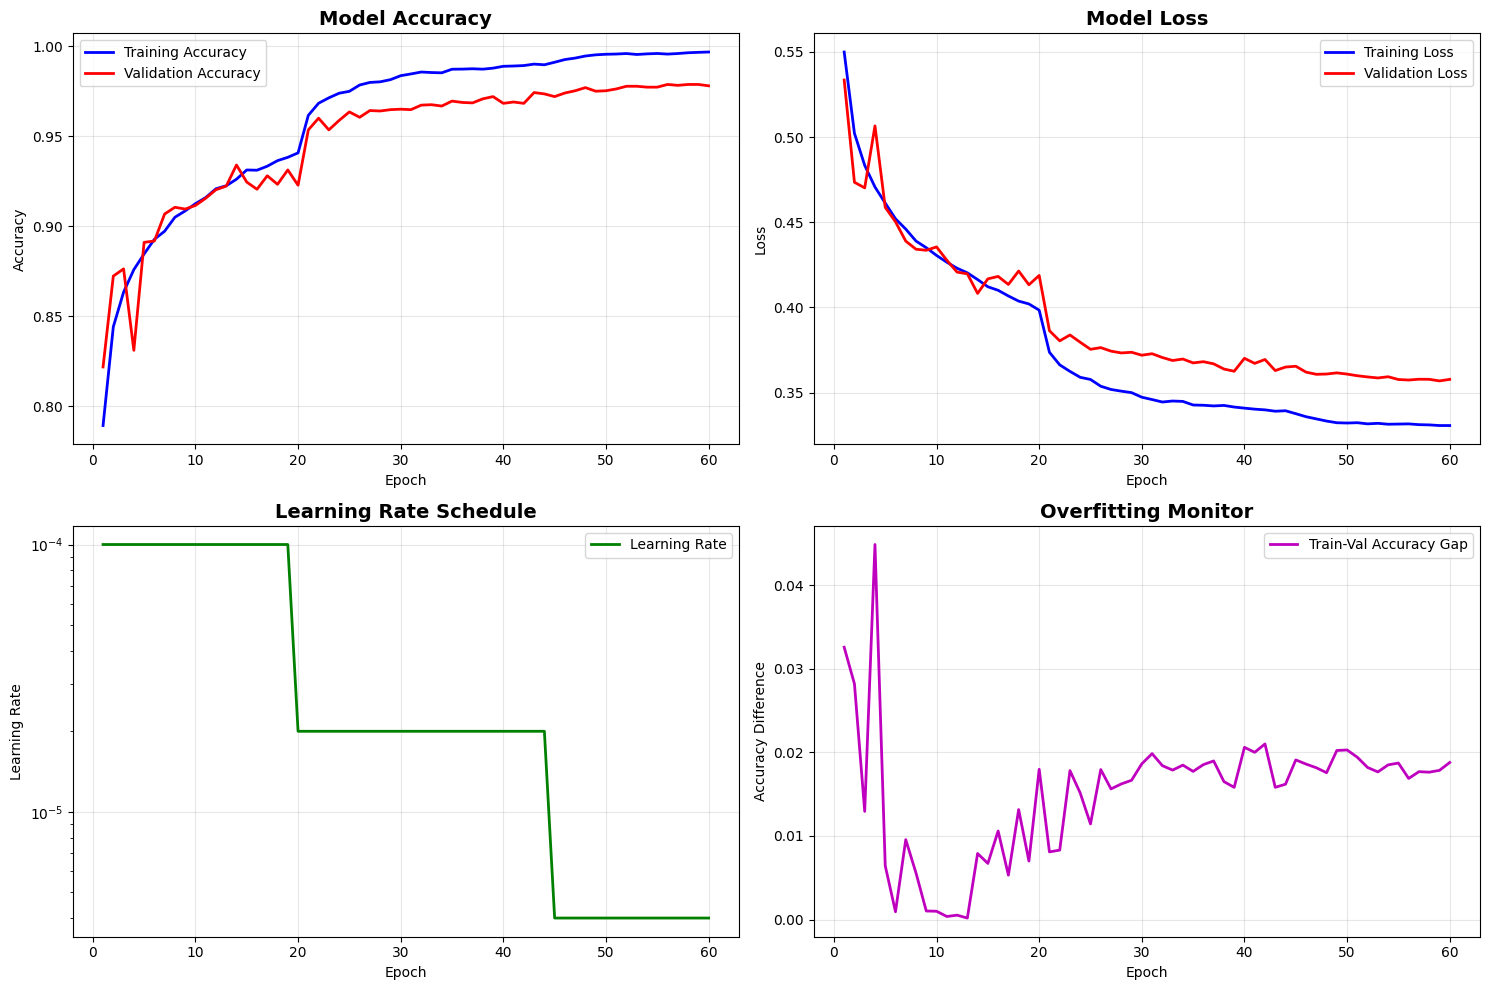

\n📊 Final Training Metrics:
Final Train Accuracy: 0.9968
Final Validation Accuracy: 0.9780
Best Validation Accuracy: 0.9788
Final Train Loss: 0.3306
Final Validation Loss: 0.3577


In [11]:
def plot_training_history(history):
    """Plot training and validation metrics"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    epochs = range(1, len(history['train_loss']) + 1)
    
    # Plot training & validation accuracy
    axes[0, 0].plot(epochs, history['train_acc'], 'b-', label='Training Accuracy', linewidth=2)
    axes[0, 0].plot(epochs, history['val_acc'], 'r-', label='Validation Accuracy', linewidth=2)
    axes[0, 0].set_title('Model Accuracy', fontsize=14, fontweight='bold')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Plot training & validation loss
    axes[0, 1].plot(epochs, history['train_loss'], 'b-', label='Training Loss', linewidth=2)
    axes[0, 1].plot(epochs, history['val_loss'], 'r-', label='Validation Loss', linewidth=2)
    axes[0, 1].set_title('Model Loss', fontsize=14, fontweight='bold')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Plot learning rate
    axes[1, 0].plot(epochs, history['lr'], 'g-', label='Learning Rate', linewidth=2)
    axes[1, 0].set_title('Learning Rate Schedule', fontsize=14, fontweight='bold')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Learning Rate')
    axes[1, 0].set_yscale('log')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Plot accuracy difference
    acc_diff = [abs(t - v) for t, v in zip(history['train_acc'], history['val_acc'])]
    axes[1, 1].plot(epochs, acc_diff, 'm-', label='Train-Val Accuracy Gap', linewidth=2)
    axes[1, 1].set_title('Overfitting Monitor', fontsize=14, fontweight='bold')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Accuracy Difference')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(RESULTS_PATH / 'training_history.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print final metrics
    print("\\n📊 Final Training Metrics:")
    print(f"Final Train Accuracy: {history['train_acc'][-1]:.4f}")
    print(f"Final Validation Accuracy: {history['val_acc'][-1]:.4f}")
    print(f"Best Validation Accuracy: {max(history['val_acc']):.4f}")
    print(f"Final Train Loss: {history['train_loss'][-1]:.4f}")
    print(f"Final Validation Loss: {history['val_loss'][-1]:.4f}")

# Plot training history
plot_training_history(history)

# Save training history
with open(RESULTS_PATH / 'training_history.json', 'w') as f:
    json.dump(history, f, indent=2)


In [12]:
def evaluate_model(model, test_loader, criterion, device):
    """Evaluate the model on test set"""
    model.eval()
    test_loss = 0.0
    test_corrects = 0
    total_samples = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        test_bar = tqdm(test_loader, desc='Testing')
        for inputs, labels in test_bar:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Statistics
            _, preds = torch.max(outputs, 1)
            test_loss += loss.item() * inputs.size(0)
            test_corrects += torch.sum(preds == labels.data)
            total_samples += inputs.size(0)
            
            # Store predictions and labels for detailed analysis
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
            # Update progress bar
            test_bar.set_postfix({
                'Loss': f'{loss.item():.4f}',
                'Acc': f'{test_corrects.double() / total_samples:.4f}'
            })
    
    test_loss = test_loss / total_samples
    test_acc = test_corrects.double() / total_samples
    
    return test_loss, test_acc.item(), all_preds, all_labels

# Evaluate on test set
print("🧪 Evaluating model on test set...")
test_loss, test_acc, test_preds, test_labels = evaluate_model(model, test_loader, criterion, device)

print(f"\\n📊 Test Results:")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)")

# Detailed classification report
print(f"\\n📋 Classification Report:")
report = classification_report(
    test_labels, 
    test_preds, 
    target_names=class_names, 
    output_dict=True
)
print(classification_report(test_labels, test_preds, target_names=class_names))

# Save classification report
with open(RESULTS_PATH / 'classification_report.json', 'w') as f:
    json.dump(report, f, indent=2)


🧪 Evaluating model on test set...


Testing: 100%|██████████| 500/500 [00:20<00:00, 23.84it/s, Loss=0.3391, Acc=0.9758]

\n📊 Test Results:
Test Loss: 0.3610
Test Accuracy: 0.9758 (97.58%)
\n📋 Classification Report:
              precision    recall  f1-score   support

     Anomaly       0.98      0.97      0.98      1988
  No-Anomaly       0.97      0.98      0.98      2012

    accuracy                           0.98      4000
   macro avg       0.98      0.98      0.98      4000
weighted avg       0.98      0.98      0.98      4000



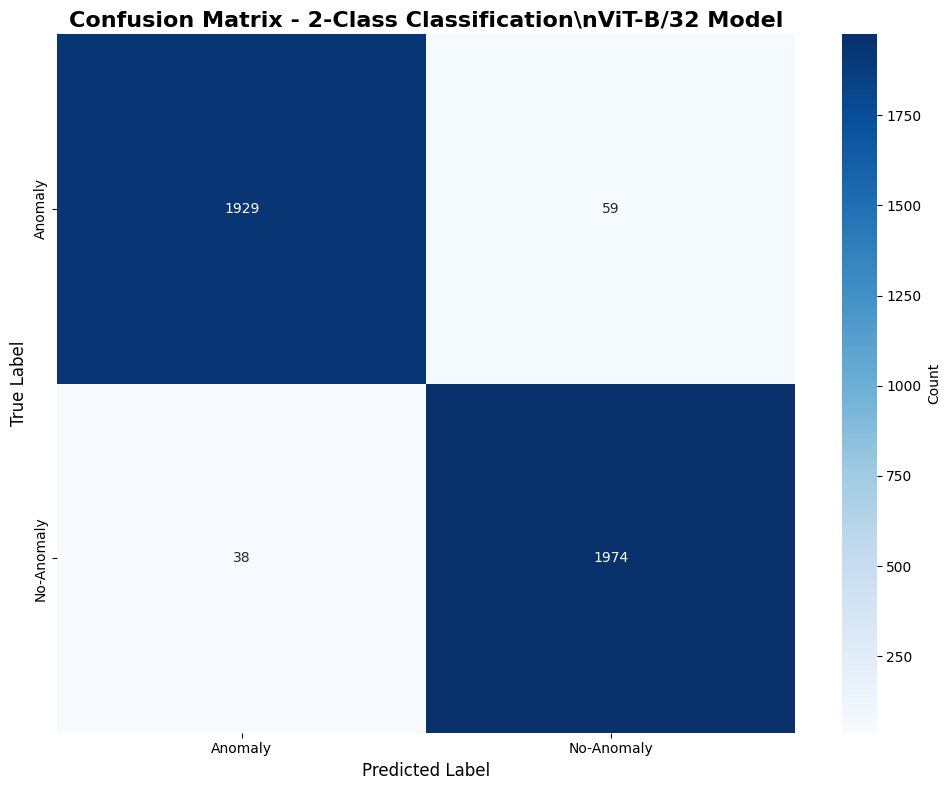

\n📈 Detailed Performance Metrics:
--------------------------------------------------
Anomaly:
  Precision: 0.9807
  Recall: 0.9703
  F1-Score: 0.9755
  Support: 1988

No-Anomaly:
  Precision: 0.9710
  Recall: 0.9811
  F1-Score: 0.9760
  Support: 2012

📊 Overall Performance:
Weighted Precision: 0.9758
Weighted Recall: 0.9758
Weighted F1-Score: 0.9757
Accuracy: 0.9758
\n✅ Training completed successfully!
📁 Model saved in: models\2_class_pytorch
📊 Results saved in: results\2_class_pytorch
🎯 Best validation accuracy: 0.9788
🧪 Final test accuracy: 0.9758
⏱️ Training duration: 4:53:00.326201


In [13]:
# Create and plot confusion matrix
cm = confusion_matrix(test_labels, test_preds)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - 2-Class Classification\\nViT-B/32 Model', fontsize=16, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.tight_layout()
plt.savefig(RESULTS_PATH / 'confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# Calculate additional metrics
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score

precision, recall, f1, support = precision_recall_fscore_support(test_labels, test_preds, average=None)

print(f"\\n📈 Detailed Performance Metrics:")
print("-" * 50)
for i, class_name in enumerate(class_names):
    print(f"{class_name}:")
    print(f"  Precision: {precision[i]:.4f}")
    print(f"  Recall: {recall[i]:.4f}")
    print(f"  F1-Score: {f1[i]:.4f}")
    print(f"  Support: {support[i]}")
    print()

# Overall metrics
overall_precision = precision_recall_fscore_support(test_labels, test_preds, average='weighted')[0]
overall_recall = precision_recall_fscore_support(test_labels, test_preds, average='weighted')[1]
overall_f1 = precision_recall_fscore_support(test_labels, test_preds, average='weighted')[2]

print(f"📊 Overall Performance:")
print(f"Weighted Precision: {overall_precision:.4f}")
print(f"Weighted Recall: {overall_recall:.4f}")
print(f"Weighted F1-Score: {overall_f1:.4f}")
print(f"Accuracy: {test_acc:.4f}")

# Create comprehensive training summary
training_summary = {
    'model_info': {
        'model_type': 'ViT-B/32',
        'framework': 'PyTorch + TIMM',
        'classification_task': '2-Class (No-Anomaly vs Anomaly)',
        'total_parameters': sum(p.numel() for p in model.parameters()),
        'trainable_parameters': sum(p.numel() for p in model.parameters() if p.requires_grad)
    },
    'dataset_info': {
        'total_samples': len(full_dataset),
        'train_samples': len(train_dataset),
        'validation_samples': len(val_dataset),
        'test_samples': len(test_dataset),
        'classes': class_names,
        'num_classes': len(class_names)
    },
    'hyperparameters': HYPERPARAMS,
    'training_info': {
        'start_time': start_time.isoformat(),
        'end_time': end_time.isoformat(),
        'duration_seconds': training_duration.total_seconds(),
        'epochs_trained': len(history['train_loss']),
        'best_val_accuracy': best_val_acc,
        'best_val_loss': best_val_loss
    },
    'final_results': {
        'test_loss': test_loss,
        'test_accuracy': test_acc,
        'overall_precision': overall_precision,
        'overall_recall': overall_recall,
        'overall_f1_score': overall_f1,
        'per_class_metrics': {
            class_names[i]: {
                'precision': precision[i],
                'recall': recall[i],
                'f1_score': f1[i],
                'support': int(support[i])
            } for i in range(len(class_names))
        }
    }
}

# Save comprehensive summary
with open(RESULTS_PATH / 'training_summary.json', 'w') as f:
    json.dump(training_summary, f, indent=2, default=str)

print(f"\\n✅ Training completed successfully!")
print(f"📁 Model saved in: {MODEL_SAVE_PATH}")
print(f"📊 Results saved in: {RESULTS_PATH}")
print(f"🎯 Best validation accuracy: {best_val_acc:.4f}")
print(f"🧪 Final test accuracy: {test_acc:.4f}")
print(f"⏱️ Training duration: {training_duration}")
